In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:


import os
import time
import random
import copy  # <-- Add this import!
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models import VGG16_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights

In [25]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [3]:

# Define dataset path
dataset_path = "./Original_Dataset"


In [4]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [5]:

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define train/val/test split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure total sums up correctly

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [6]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Number of classes
num_classes = len(full_dataset.classes)
print(f"Classes: {full_dataset.classes}, Total Classes: {num_classes}")

# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {cls: 0 for cls in dataset.dataset.classes}
    for _, label in dataset.dataset.samples:
        class_counts[dataset.dataset.classes[label]] += 1
    return class_counts

# Get the count of images per class
class_counts = count_images_per_class(train_dataset)

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa'], Total Classes: 10
Class 'Central Serous Chorioretinopathy [Color Fundus]': 101 images
Class 'Diabetic Retinopathy': 1509 images
Class 'Disc Edema': 127 images
Class 'Glaucoma': 1349 images
Class 'Healthy': 1024 images
Class 'Macular Scar': 444 images
Class 'Myopia': 500 images
Class 'Pterygium': 17 images
Class 'Retinal Detachment': 125 images
Class 'Retinitis Pigmentosa': 139 images


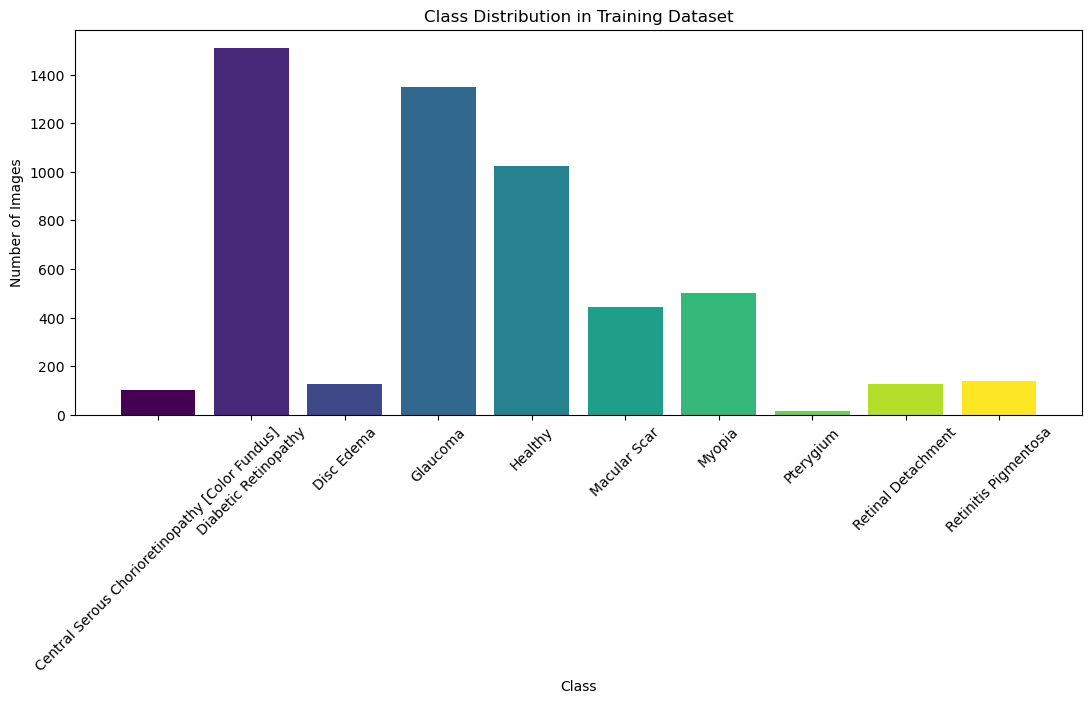

In [8]:

train_class_counts = count_images_per_class(train_dataset)

# Generate a list of colors based on the number of classes
colors = plt.cm.viridis(np.linspace(0, 1, len(train_class_counts)))

# Plot class distribution with different colors
plt.figure(figsize=(13, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

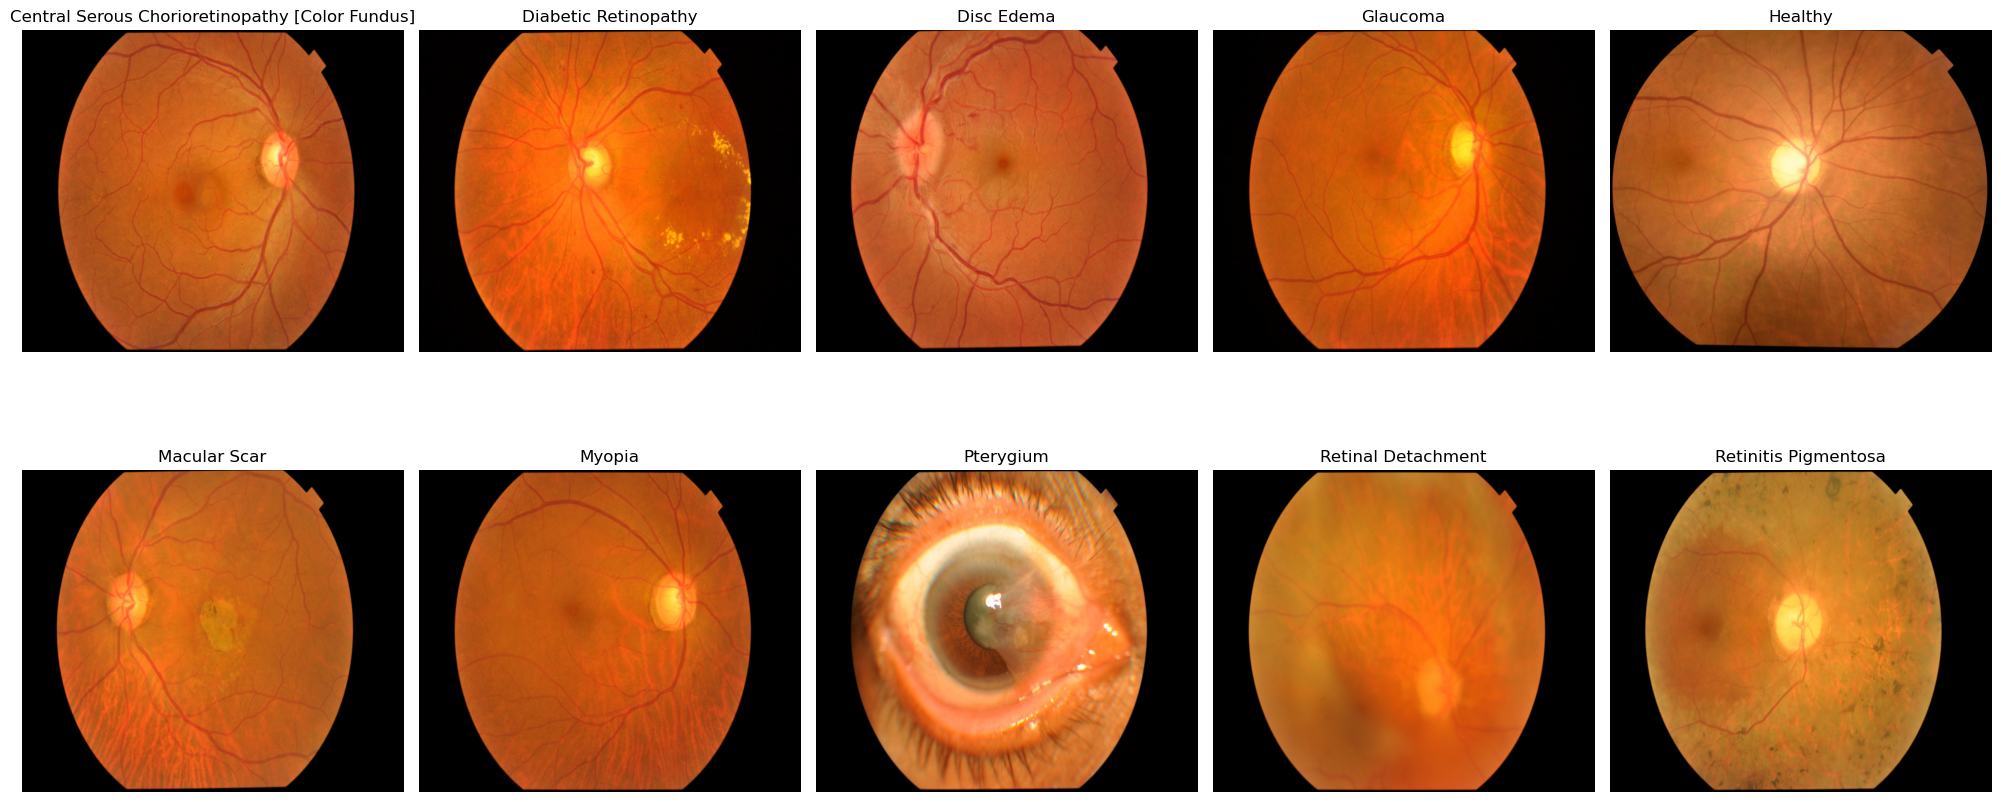

In [9]:


def show_random_images(dataset, num_images=1):
    # Create a grid with 5 images per row
    rows = len(dataset.dataset.classes) // 5 + (len(dataset.dataset.classes) % 5 > 0)
    fig, axes = plt.subplots(rows, 5, figsize=(20, 5 * rows))

    # Flatten axes in case the grid is not fully filled (when the number of classes is not a multiple of 5)
    axes = axes.flatten()

    for idx, cls in enumerate(dataset.dataset.classes):
        # Get the indices for images of the current class
        class_indices = [i for i, (_, label) in enumerate(dataset.dataset.samples) if dataset.dataset.classes[label] == cls]
        
        # Choose a random index for the class
        random_idx = random.choice(class_indices)
        img_path, _ = dataset.dataset.samples[random_idx]

        # Open and display the image
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(cls)

    # Hide any unused axes (in case the number of classes is not divisible by 5)
    for i in range(len(dataset.dataset.classes), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Show one random image per class
show_random_images(train_dataset)

In [ ]:

# import torchvision.models as models
# from torchvision.models import VGG16_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights

# def get_model(model_name, num_classes, freeze_layers=True):
#     if model_name == "MobileNetV3":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier = nn.Sequential(
#             nn.Linear(model.classifier[0].in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(512, num_classes)
#         )
    
#     elif model_name == "VGG16":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.vgg16(weights=VGG16_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    
#     elif model_name == "DenseNet121":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier = nn.Linear(model.classifier.in_features, num_classes)

#     return model.to(device)


In [ ]:

# class EarlyStopping:
#     def __init__(self, patience=5):
#         self.patience = patience
#         self.best_loss = float('inf')
#         self.counter = 0

#     def should_stop(self, val_loss):
#         if val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#         return self.counter >= self.patience

In [ ]:


# def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
#     train_losses, val_losses = [], []

#     for epoch in range(epochs):
#         start_time = time.time()
        
#         model.train()
#         train_loss, correct_train = 0, 0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             correct_train += (outputs.argmax(1) == labels).sum().item()
        
#         train_acc = correct_train / len(train_loader.dataset)
#         train_loss /= len(train_loader)

#         model.eval()
#         val_loss, correct_val = 0, 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 correct_val += (outputs.argmax(1) == labels).sum().item()
        
#         val_acc = correct_val / len(val_loader.dataset)
#         val_loss /= len(val_loader)

#         scheduler.step(val_loss)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         epoch_time = time.time() - start_time
#         print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

#         if early_stopping.should_stop(val_loss):
#             print("Early stopping triggered.")
#             break

#     return train_losses, val_losses

In [ ]:


# models_list = ["VGG16"]
# optimizers_list = [optim.Adam]

# best_model, best_loss = None, float("inf")

# for model_name in models_list:
#     for optimizer_type in optimizers_list:
#         print(f"\nTraining {model_name} with {optimizer_type.__name__} optimizer...\n")

#         model = get_model(model_name, num_classes)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optimizer_type(model.parameters(), lr=0.001)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
#         early_stopping = EarlyStopping(patience=5)

#         train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping)

#         if val_losses[-1] < best_loss:
#             best_loss = val_losses[-1]
#             best_model = model_name

# print(f"\nBest Model: {best_model} with lowest validation loss: {best_loss:.4f}")

In [22]:

def get_model_mobilenetv3(num_classes, freeze_layers=True):
    # Load MobileNetV3 with pre-trained weights
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    
    if freeze_layers:
        # Freeze all blocks in model.features except for the last two modules
        total_blocks = len(model.features)
        for idx, module in enumerate(model.features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                # Unfreeze last two blocks
                for param in module.parameters():
                    param.requires_grad = True
    # Replace classifier with a custom head that includes dropout
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

   

In [23]:

def get_model_densenet121(num_classes, freeze_layers=True):
    # Load DenseNet121 with pre-trained weights
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    
    if freeze_layers:
        # For DenseNet121, model.features is a Sequential of various layers.
        # Unfreeze only the last two modules.
        features = list(model.features.children())
        total_blocks = len(features)
        for idx, module in enumerate(features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                for param in module.parameters():
                    param.requires_grad = True
        # Note: The model.features remains a Sequential container.
    # Replace classifier with dropout and a linear layer.
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier.in_features, num_classes)
    )
    return model.to(device)


In [12]:


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [14]:

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    all_val_labels, all_val_preds = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
        
        if early_stopping.should_stop(val_loss):
            print("Early stopping triggered.")
            break
        
        if val_loss < early_stopping.best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs, all_val_labels, all_val_preds

In [15]:

def plot_accuracy_and_loss(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    
    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



In [16]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_accuracy, color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.xticks(rotation=45)
    plt.show()

In [17]:

class_names = full_dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)  # ensure class_names is defined from your dataset
epochs = 20
learning_rate = 0.001

Classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


In [26]:

print("\nTraining MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...\n")
mobilenet_model = get_model_mobilenetv3(num_classes, freeze_layers=True)
optimizer_mnv3 = optim.Adam(mobilenet_model.parameters(), lr=learning_rate)
scheduler_mnv3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mnv3, mode='min', factor=0.1, patience=3)
early_stopping_mnv3 = EarlyStopping(patience=5)

mobilenet_model, train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3, val_labels_mnv3, val_preds_mnv3 = train_model(
    mobilenet_model, nn.CrossEntropyLoss(), optimizer_mnv3, scheduler_mnv3,
    train_loader, val_loader, early_stopping_mnv3, epochs=epochs
)





Training MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...

Epoch 1/20 - Train Acc: 0.5969, Train Loss: 1.1494, Val Acc: 0.5820, Val Loss: 1.4434, Time: 187.00s
Epoch 2/20 - Train Acc: 0.7244, Train Loss: 0.7313, Val Acc: 0.6739, Val Loss: 1.1559, Time: 181.09s
Epoch 3/20 - Train Acc: 0.7807, Train Loss: 0.5840, Val Acc: 0.7001, Val Loss: 1.0335, Time: 182.22s
Epoch 4/20 - Train Acc: 0.8163, Train Loss: 0.4728, Val Acc: 0.6888, Val Loss: 1.0163, Time: 182.23s
Epoch 5/20 - Train Acc: 0.8508, Train Loss: 0.4030, Val Acc: 0.6842, Val Loss: 1.0103, Time: 180.80s
Epoch 6/20 - Train Acc: 0.8621, Train Loss: 0.3442, Val Acc: 0.6635, Val Loss: 1.1230, Time: 181.15s
Epoch 7/20 - Train Acc: 0.8830, Train Loss: 0.2927, Val Acc: 0.6823, Val Loss: 1.2764, Time: 182.26s
Epoch 8/20 - Train Acc: 0.8913, Train Loss: 0.2691, Val Acc: 0.6832, Val Loss: 1.1948, Time: 181.46s
Epoch 9/20 - Train Acc: 0.8969, Train Loss: 0.2469, Val Acc: 0.6757, Val Loss: 1.4595, Time: 181.19s
Epoch 10/20 - Train 


MobileNetV3 Training Completed.



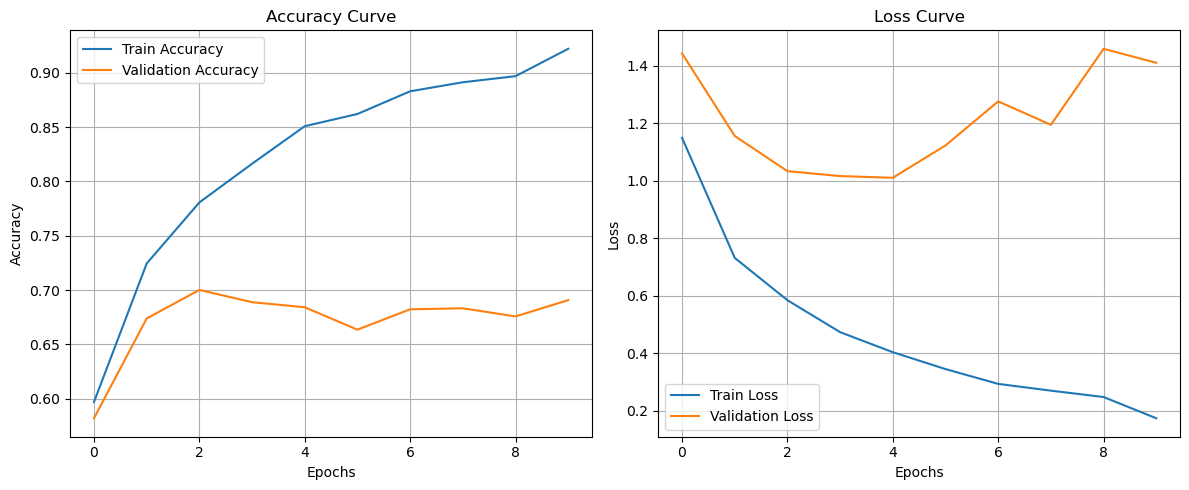

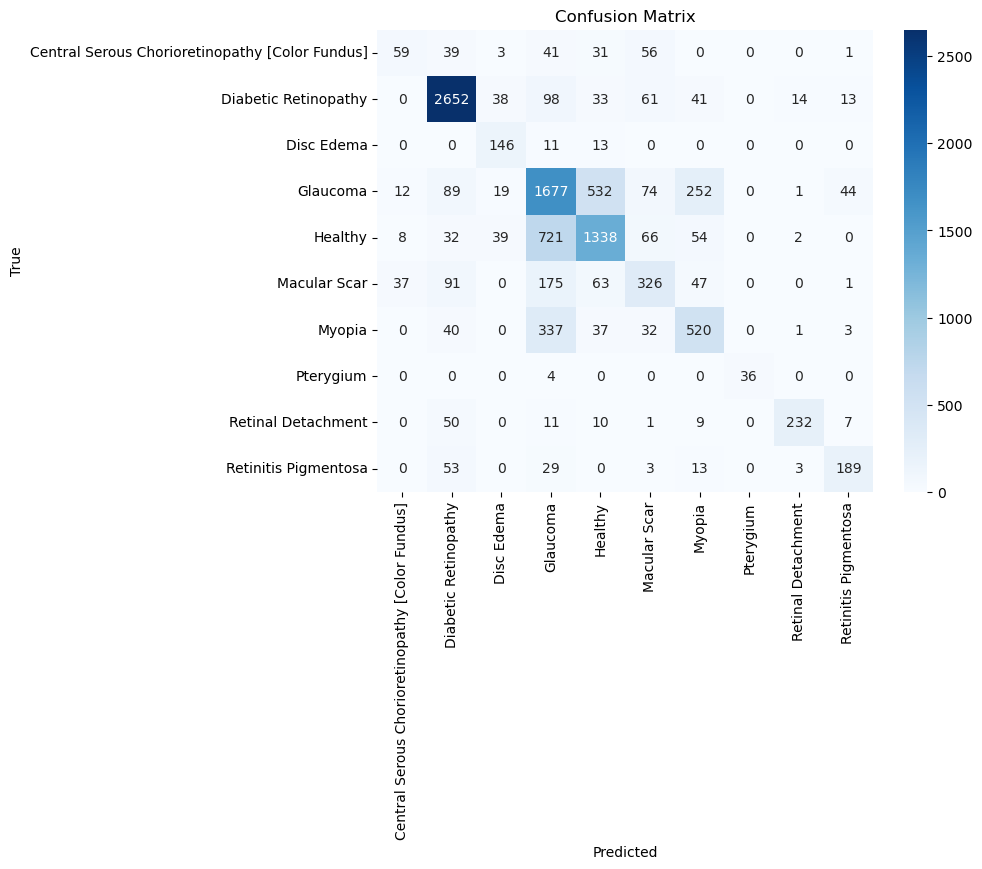

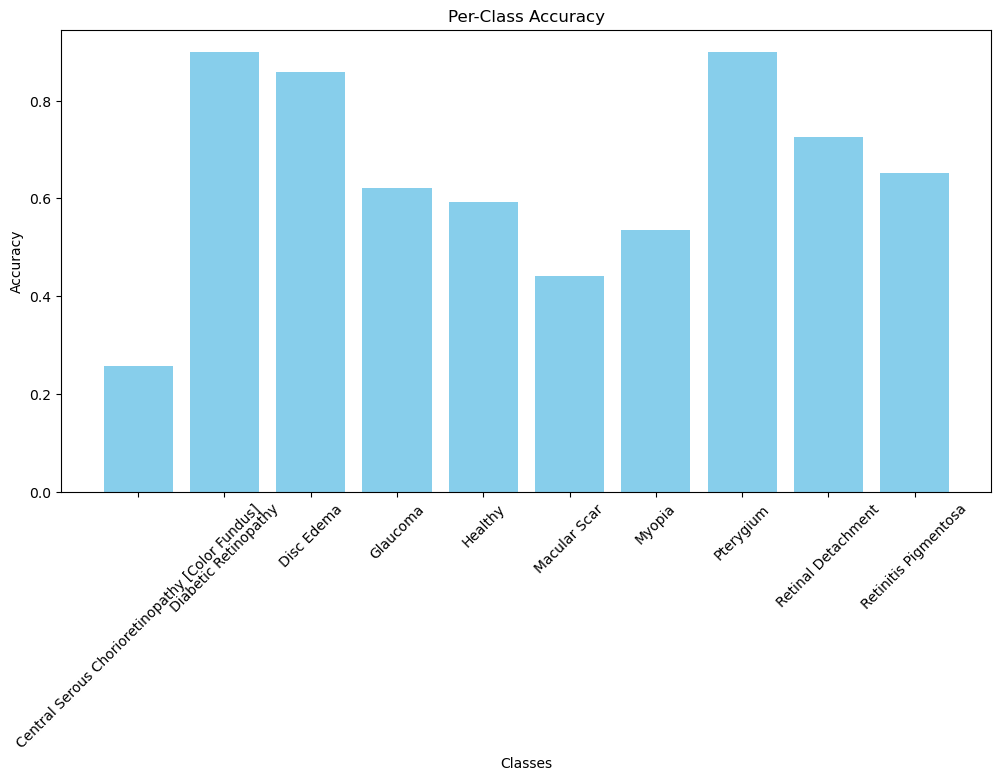

In [27]:


print("\nMobileNetV3 Training Completed.\n")
plot_accuracy_and_loss(train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3)
plot_confusion_matrix(val_labels_mnv3, val_preds_mnv3, class_names)
plot_per_class_accuracy(val_labels_mnv3, val_preds_mnv3, class_names)


In [28]:

import torch
import numpy as np

def compute_classification_metrics(y_true, y_pred, num_classes, class_names):
    """
    Compute precision, recall, and F1-score for each class using PyTorch.

    Args:
        y_true (list or np.array): True labels from validation set
        y_pred (list or np.array): Predicted labels from validation set
        num_classes (int): Number of classes in dataset
        class_names (list): Class names for better readability
    
    Returns:
        None (Prints classification report)
    """
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    
    # Initialize TP, FP, FN
    true_positive = torch.zeros(num_classes)
    false_positive = torch.zeros(num_classes)
    false_negative = torch.zeros(num_classes)

    # Compute TP, FP, FN for each class
    for i in range(num_classes):
        true_positive[i] = ((y_pred == i) & (y_true == i)).sum().item()
        false_positive[i] = ((y_pred == i) & (y_true != i)).sum().item()
        false_negative[i] = ((y_pred != i) & (y_true == i)).sum().item()

    # Compute precision, recall, and F1-score
    precision = true_positive / (true_positive + false_positive + 1e-8)  # Avoid division by zero
    recall = true_positive / (true_positive + false_negative + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Print results
    print("\nClassification Report MobileNetV3:\n")
    print(f"{'Class':<15}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}")
    print("=" * 50)
    for i in range(num_classes):
        print(f"{class_names[i]:<15}{precision[i].item():<12.4f}{recall[i].item():<12.4f}{f1_score[i].item():<12.4f}")

    # Compute overall accuracy
    accuracy = (y_pred == y_true).sum().item() / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Example Usage:
compute_classification_metrics(val_labels_mnv3, val_preds_mnv3, num_classes, class_names)



Classification Report MobileNetV3:

Class          Precision   Recall      F1-Score    
Central Serous Chorioretinopathy [Color Fundus]0.5086      0.2565      0.3410      
Diabetic Retinopathy0.8707      0.8990      0.8846      
Disc Edema     0.5959      0.8588      0.7036      
Glaucoma       0.5403      0.6211      0.5779      
Healthy        0.6505      0.5920      0.6199      
Macular Scar   0.5267      0.4405      0.4798      
Myopia         0.5556      0.5361      0.5456      
Pterygium      1.0000      0.9000      0.9474      
Retinal Detachment0.9170      0.7250      0.8098      
Retinitis Pigmentosa0.7326      0.6517      0.6898      

Overall Accuracy: 0.6724



In [29]:

# ----- DenseNet121 -----
print("\nTraining DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...\n")
densenet_model = get_model_densenet121(num_classes, freeze_layers=True)
optimizer_dn = optim.Adam(densenet_model.parameters(), lr=learning_rate)
scheduler_dn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dn, mode='min', factor=0.1, patience=3)
early_stopping_dn = EarlyStopping(patience=5)

densenet_model, train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn, val_labels_dn, val_preds_dn = train_model(
    densenet_model, nn.CrossEntropyLoss(), optimizer_dn, scheduler_dn,
    train_loader, val_loader, early_stopping_dn, epochs=epochs
)




Training DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/shruti/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 13.2MB/s]


Epoch 1/20 - Train Acc: 0.6591, Train Loss: 0.9648, Val Acc: 0.7366, Val Loss: 0.7529, Time: 204.61s
Epoch 2/20 - Train Acc: 0.7638, Train Loss: 0.6737, Val Acc: 0.7245, Val Loss: 0.7353, Time: 198.22s
Epoch 3/20 - Train Acc: 0.7981, Train Loss: 0.5478, Val Acc: 0.7413, Val Loss: 0.7443, Time: 199.48s
Epoch 4/20 - Train Acc: 0.8222, Train Loss: 0.4674, Val Acc: 0.7020, Val Loss: 0.8298, Time: 197.56s
Epoch 5/20 - Train Acc: 0.8259, Train Loss: 0.4486, Val Acc: 0.7057, Val Loss: 0.8883, Time: 196.95s
Epoch 6/20 - Train Acc: 0.8527, Train Loss: 0.3907, Val Acc: 0.6804, Val Loss: 1.0310, Time: 199.69s
Epoch 7/20 - Train Acc: 0.9004, Train Loss: 0.2713, Val Acc: 0.7188, Val Loss: 0.8719, Time: 380.95s
Early stopping triggered.



DenseNet121 Training Completed.



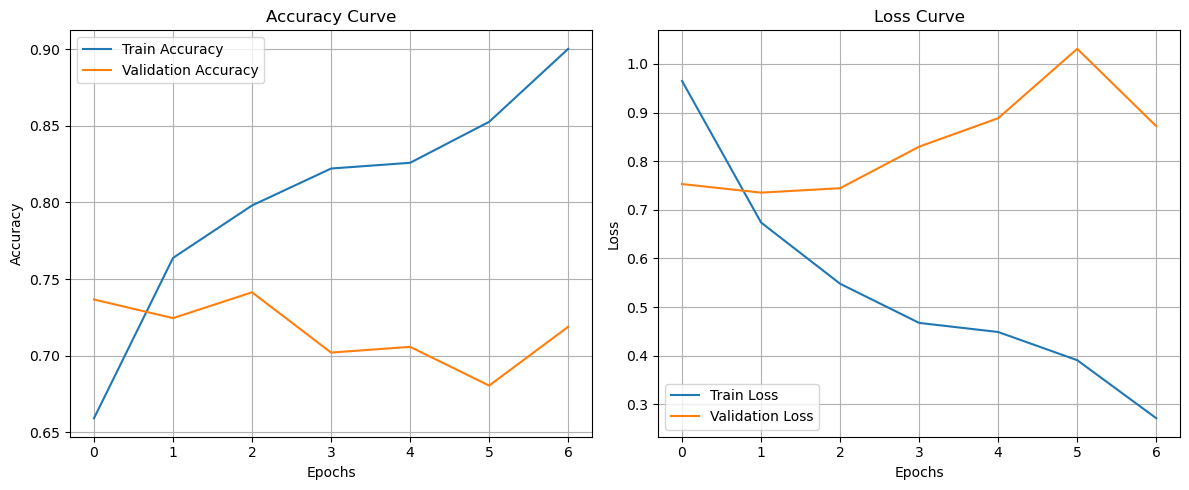

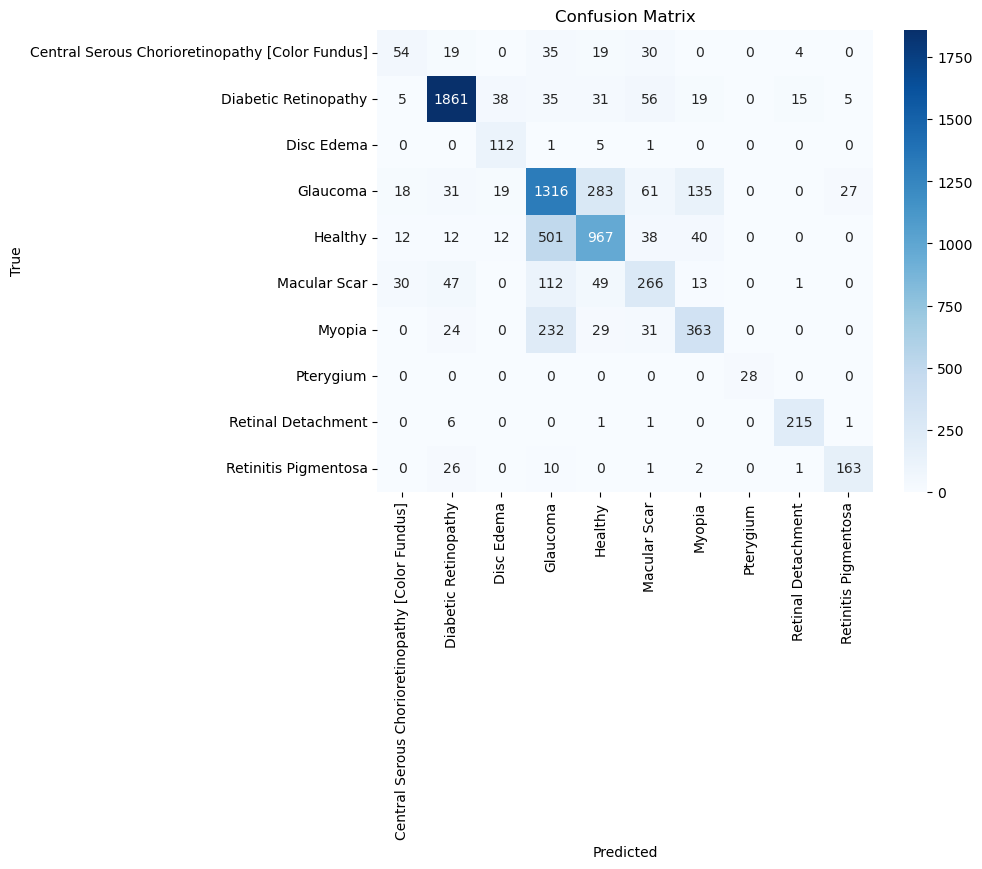

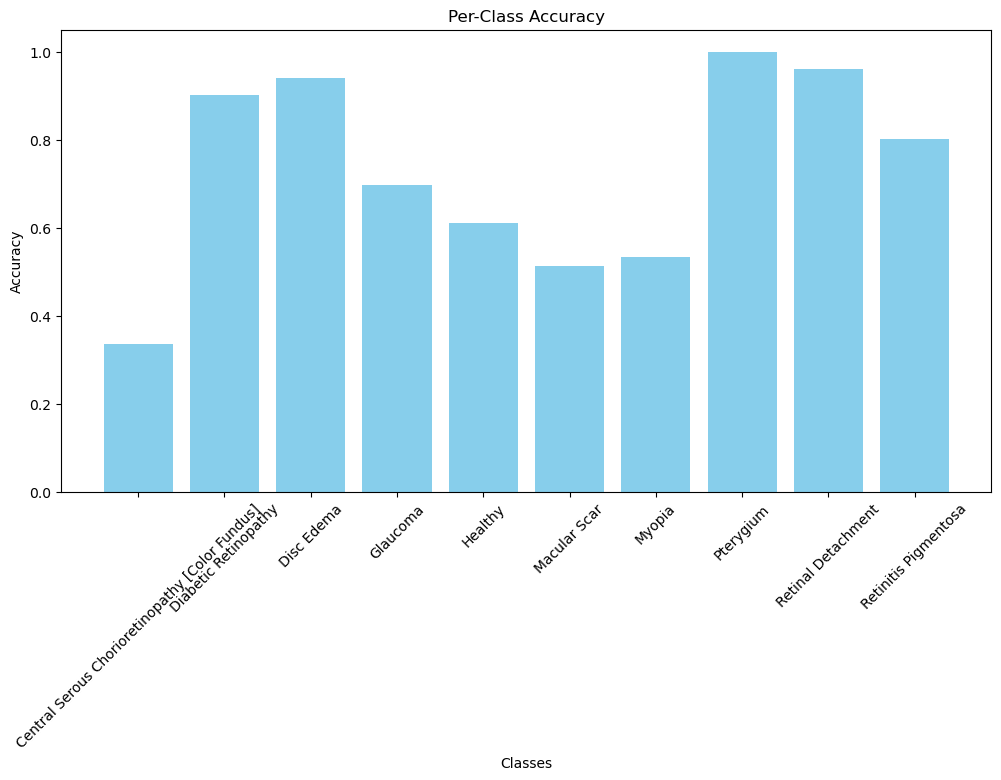

In [30]:


print("\nDenseNet121 Training Completed.\n")
plot_accuracy_and_loss(train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn)
plot_confusion_matrix(val_labels_dn, val_preds_dn, class_names)
plot_per_class_accuracy(val_labels_dn, val_preds_dn, class_names)


In [31]:

compute_classification_metrics(val_labels_dn, val_preds_dn, num_classes, class_names)



Classification Report MobileNetV3:

Class          Precision   Recall      F1-Score    
Central Serous Chorioretinopathy [Color Fundus]0.4538      0.3354      0.3857      
Diabetic Retinopathy0.9186      0.9012      0.9098      
Disc Edema     0.6188      0.9412      0.7467      
Glaucoma       0.5870      0.6963      0.6370      
Healthy        0.6987      0.6113      0.6521      
Macular Scar   0.5485      0.5135      0.5304      
Myopia         0.6346      0.5346      0.5803      
Pterygium      1.0000      1.0000      1.0000      
Retinal Detachment0.9110      0.9598      0.9348      
Retinitis Pigmentosa0.8316      0.8030      0.8170      

Overall Accuracy: 0.7156

